<a href="https://colab.research.google.com/github/gabe2207/Predictive-Analysis-of-Churn-in-Telecommunications/blob/main/Relatorio%20Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pré-processamento

##Extração da base e análises

A base utilizada será a cell2cell [Telecom churn cell2cell](https://www.kaggle.com/datasets/jpacse/datasets-for-churn-telecom). Ela consiste em 51,047 instâncias de 57 atributos referentes à clientes do serviço de telecomunicação, com o rótulo sendo a sua permanência (ou não) na utilização desse serviço. Essa base conta com um arquivo holdout que não será utilizado dado a ausência de rótulos, inviabilizando a aprendizagem supervisionada que será adotada.



In [ ]:
import pandas as pd
train_path_file = '/content/drive/MyDrive/IA - Projeto Final/cell2celltrain.csv'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_train = pd.read_csv(train_path_file)
train_df = pd.DataFrame(data = data_train)

Como mostrado no gráfico abaixo, um aspecto a ser levado em consideração é a característica imbalanceada da base. 71.2% dos das instâncias resultam em "No Churn", enquanto 28.8% resultam em "Churn".

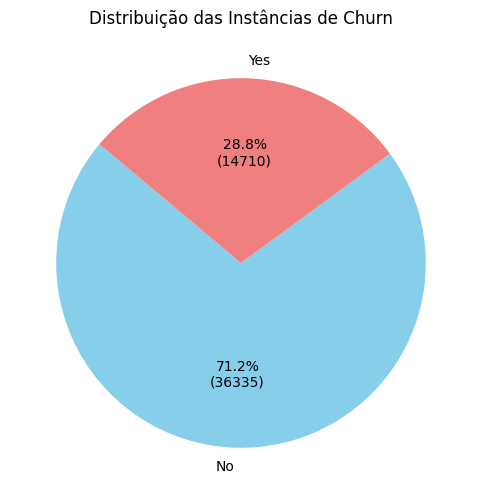

In [ ]:
import matplotlib.pyplot as plt

# Contar a frequência de cada valor na coluna 'Churn'
churn_counts = train_df['Churn'].value_counts()

# Função para adicionar a quantidade de instâncias no gráfico de pizza
def func(pct, allvalues):
    absolute = int(pct / 100.*sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Plotar o gráfico de pizza
plt.figure(figsize=(8, 6))
plt.pie(churn_counts, labels=churn_counts.index, autopct=lambda pct: func(pct, churn_counts), startangle=140, colors=['skyblue', 'lightcoral'])
plt.title('Distribuição das Instâncias de Churn')
plt.show()


O próximo gráfico mostra a proporção dos diferentes tipos de dados encontrados na base. 39.7% dos atributos necessitarão de codificadores, dado que os modelos utilizados recebem valores numéricos como entrada.

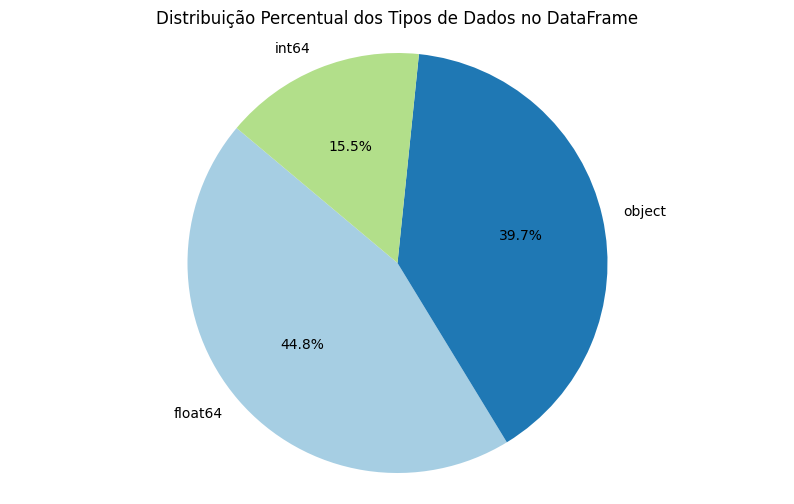

In [ ]:
dtype_counts = train_df.dtypes.value_counts()
plt.figure(figsize=(10, 6))
plt.pie(dtype_counts, labels=dtype_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(dtype_counts))))
plt.title('Distribuição Percentual dos Tipos de Dados no DataFrame')
plt.axis('equal')
plt.show()


In [ ]:
train_df.columns

Index(['CustomerID', 'Churn', 'MonthlyRevenue', 'MonthlyMinutes',
       'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes',
       'RoamingCalls', 'PercChangeMinutes', 'PercChangeRevenues',
       'DroppedCalls', 'BlockedCalls', 'UnansweredCalls', 'CustomerCareCalls',
       'ThreewayCalls', 'ReceivedCalls', 'OutboundCalls', 'InboundCalls',
       'PeakCallsInOut', 'OffPeakCallsInOut', 'DroppedBlockedCalls',
       'CallForwardingCalls', 'CallWaitingCalls', 'MonthsInService',
       'UniqueSubs', 'ActiveSubs', 'ServiceArea', 'Handsets', 'HandsetModels',
       'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2', 'ChildrenInHH',
       'HandsetRefurbished', 'HandsetWebCapable', 'TruckOwner', 'RVOwner',
       'Homeownership', 'BuysViaMailOrder', 'RespondsToMailOffers',
       'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard',
       'RetentionCalls', 'RetentionOffersAccepted', 'NewCellphoneUser',
       'NotNewCellphoneUser', 'ReferralsMadeBySubscriber', 'IncomeGro

Os seguintes atributos (CustomerID e ServiceArea) serão descartados, o primeiro não é útil para a construção do conhecimento, e o seguindo consiste em uma string encriptada.


In [ ]:
train_df = train_df.drop(['CustomerID','ServiceArea'], axis=1)

Como demonstrado pelo código a seguir, é também necessário tratar o valores faltantes em diversos atributos da base.

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51047 entries, 0 to 51046
Data columns (total 56 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Churn                      51047 non-null  object 
 1   MonthlyRevenue             50891 non-null  float64
 2   MonthlyMinutes             50891 non-null  float64
 3   TotalRecurringCharge       50891 non-null  float64
 4   DirectorAssistedCalls      50891 non-null  float64
 5   OverageMinutes             50891 non-null  float64
 6   RoamingCalls               50891 non-null  float64
 7   PercChangeMinutes          50680 non-null  float64
 8   PercChangeRevenues         50680 non-null  float64
 9   DroppedCalls               51047 non-null  float64
 10  BlockedCalls               51047 non-null  float64
 11  UnansweredCalls            51047 non-null  float64
 12  CustomerCareCalls          51047 non-null  float64
 13  ThreewayCalls              51047 non-null  flo

##Formatação de valores

A coluna HandsetPrice inicialmente conta com valores inteiros e instâncias como "unknown". Para essas instâncias, será calculado uma média dos valores para impor uma neutralidade na falta de valores.

In [ ]:
# HandsetPrice (ints e 1 unknown),
train_df['HandsetPrice'] = pd.to_numeric(train_df['HandsetPrice'], errors='coerce')
mean_value = train_df['HandsetPrice'].mean()
train_df['HandsetPrice'].fillna(mean_value, inplace=True)
print(train_df['HandsetPrice'].unique())

[ 30.          82.23793338  10.          80.         150.
 300.          40.         200.         100.         130.
  60.         400.         240.         250.         180.
 500.        ]


## Codificação de dados ordinais

Os 4 atributos ordinais da base que não estão em formato numerico serão codificados com OrdinalEncoder.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

credit_rating = ['7-Lowest', '6-VeryLow', '5-Low', '4-Medium', '3-Good', '2-High', '1-Highest']
status = ['No', 'Yes']

credit_rating_enc = OrdinalEncoder(categories=[credit_rating])
status_enc_churn = OrdinalEncoder(categories=[status])
status_enc_credit_card = OrdinalEncoder(categories=[status])
status_enc_owns_computer = OrdinalEncoder(categories=[status])

train_df['CreditRating'] = credit_rating_enc.fit_transform(train_df[['CreditRating']])
train_df['Churn'] = status_enc_churn.fit_transform(train_df[['Churn']])
train_df['HasCreditCard'] = status_enc_credit_card.fit_transform(train_df[['HasCreditCard']])
train_df['OwnsComputer'] = status_enc_owns_computer.fit_transform(train_df[['OwnsComputer']])


##Codificação de dados categóricos

Os 17 atributos nominais da classe que não estão em formato numérico serão encodados utilizando o OneHotEncoder

In [ ]:
from sklearn.preprocessing import OneHotEncoder


categorical_columns = ['ChildrenInHH', 'HandsetRefurbished', 'HandsetWebCapable', 'TruckOwner', 'RVOwner', 'Homeownership',
                       'BuysViaMailOrder', 'RespondsToMailOffers', 'OptOutMailings', 'NonUSTravel', 'NewCellphoneUser',
                       'NotNewCellphoneUser', 'OwnsMotorcycle', 'MadeCallToRetentionTeam', 'MaritalStatus','Occupation','PrizmCode']
#These columns contains values differing from 'yes','no': MaritalStatus (No, Yes, Unknown),  Homeownership (Known, Unknown)
# Occupation (Professional, Crafts, Other, Self, Retired, Homemaker, Clerical, Student)
# PrizmCode (Suburban, Town, Other, Rural),
for col in categorical_columns:
    train_df[col] = train_df[col].astype('category').cat.codes.astype(float)

ohe = OneHotEncoder(handle_unknown= 'ignore', sparse_output = False).set_output(transform = 'pandas')
ohetransform = ohe.fit_transform(train_df[categorical_columns])
ohetransform = ohetransform.astype(float)
ohetransform


,ChildrenInHH_0.0,ChildrenInHH_1.0,HandsetRefurbished_0.0,HandsetRefurbished_1.0,HandsetWebCapable_0.0,HandsetWebCapable_1.0,TruckOwner_0.0,TruckOwner_1.0,RVOwner_0.0,RVOwner_1.0,...,Occupation_2.0,Occupation_3.0,Occupation_4.0,Occupation_5.0,Occupation_6.0,Occupation_7.0,PrizmCode_0.0,PrizmCode_1.0,PrizmCode_2.0,PrizmCode_3.0
0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51042,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
51043,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
51044,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
51045,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
train_df = pd.concat([train_df, ohetransform], axis=1).drop(columns = categorical_columns)
train_df.head()

,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,...,Occupation_2.0,Occupation_3.0,Occupation_4.0,Occupation_5.0,Occupation_6.0,Occupation_7.0,PrizmCode_0.0,PrizmCode_1.0,PrizmCode_2.0,PrizmCode_3.0
0,1.0,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,0.7,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,0.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,52.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


##Tratamento de dados faltantes


Para os dados faltantes, será utilizado o método de utilizar a média das instâncias da categoria

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51047 entries, 0 to 51046
Data columns (total 82 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Churn                        51047 non-null  float64
 1   MonthlyRevenue               50891 non-null  float64
 2   MonthlyMinutes               50891 non-null  float64
 3   TotalRecurringCharge         50891 non-null  float64
 4   DirectorAssistedCalls        50891 non-null  float64
 5   OverageMinutes               50891 non-null  float64
 6   RoamingCalls                 50891 non-null  float64
 7   PercChangeMinutes            50680 non-null  float64
 8   PercChangeRevenues           50680 non-null  float64
 9   DroppedCalls                 51047 non-null  float64
 10  BlockedCalls                 51047 non-null  float64
 11  UnansweredCalls              51047 non-null  float64
 12  CustomerCareCalls            51047 non-null  float64
 13  ThreewayCalls   

In [ ]:
from sklearn.impute import SimpleImputer

columns_with_missing = train_df.columns[train_df.isna().any()].tolist()
imputer = SimpleImputer(strategy='mean')
df_numerics = train_df[columns_with_missing].select_dtypes(include=['float64', 'int64'])
df_numerics_imputed = pd.DataFrame(imputer.fit_transform(df_numerics), columns=df_numerics.columns)
train_df[columns_with_missing] = df_numerics_imputed

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51047 entries, 0 to 51046
Data columns (total 82 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Churn                        51047 non-null  float64
 1   MonthlyRevenue               51047 non-null  float64
 2   MonthlyMinutes               51047 non-null  float64
 3   TotalRecurringCharge         51047 non-null  float64
 4   DirectorAssistedCalls        51047 non-null  float64
 5   OverageMinutes               51047 non-null  float64
 6   RoamingCalls                 51047 non-null  float64
 7   PercChangeMinutes            51047 non-null  float64
 8   PercChangeRevenues           51047 non-null  float64
 9   DroppedCalls                 51047 non-null  float64
 10  BlockedCalls                 51047 non-null  float64
 11  UnansweredCalls              51047 non-null  float64
 12  CustomerCareCalls            51047 non-null  float64
 13  ThreewayCalls   

##Padronização StandardScaler

In [ ]:
from sklearn.preprocessing import StandardScaler
y = train_df['Churn']
X = train_df.drop(columns = ['Churn'])
scaler_standard = StandardScaler()
X_standard_scaled = scaler_standard.fit_transform(X)
X_df = pd.DataFrame(X_standard_scaled, columns=X.columns)
train_df = pd.concat([X_df, y], axis=1)

##Padronização MinMax

O intervalo numério entre os atributos difere significadamente, como Pode ser observado no código a seguir. Para que nenhuma classe seja dominante, será adotada a estratégia de padronização MinMax.

In [ ]:
train_df.describe().round(3)

,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,...,Occupation_3.0,Occupation_4.0,Occupation_5.0,Occupation_6.0,Occupation_7.0,PrizmCode_0.0,PrizmCode_1.0,PrizmCode_2.0,PrizmCode_3.0,Churn
count,51047.000,51047.000,51047.000,51047.000,51047.000,51047.000,51047.000,51047.000,51047.000,51047.000,...,51047.000,51047.000,51047.000,51047.000,51047.000,51047.000,51047.000,51047.000,51047.000,51047.000
mean,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,...,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.288
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.453
min,-1.463,-0.994,-2.429,-0.402,-0.415,-0.126,-15.057,-28.061,-0.665,-0.373,...,-1.675,-0.455,-0.121,-0.132,-0.087,-0.967,-0.223,-0.687,-0.418,0.000
25%,-0.566,-0.693,-0.707,-0.402,-0.415,-0.126,-0.275,-0.145,-0.587,-0.373,...,-1.675,-0.455,-0.121,-0.132,-0.087,-0.967,-0.223,-0.687,-0.418,0.000
50%,-0.230,-0.298,-0.077,-0.290,-0.384,-0.126,0.022,0.023,-0.333,-0.282,...,0.597,-0.455,-0.121,-0.132,-0.087,-0.967,-0.223,-0.687,-0.418,0.000
75%,0.273,0.371,0.553,0.043,0.000,-0.096,0.298,0.070,0.187,-0.035,...,0.597,-0.455,-0.121,-0.132,-0.087,1.035,-0.223,1.455,-0.418,1.000
max,26.206,12.916,14.831,71.230,44.390,113.347,20.280,63.012,23.849,34.733,...,0.597,2.198,8.285,7.555,11.532,1.035,4.478,1.455,2.393,1.000


In [ ]:
"""
from sklearn.preprocessing import MinMaxScaler
y = train_df['Churn']
X = train_df.drop(columns = ['Churn'])
scaler_minmax = MinMaxScaler()
X_minmax_scaled = scaler_minmax.fit_transform(X)
X_df = pd.DataFrame(X_minmax_scaled, columns=X.columns)
train_df = pd.concat([X_df, y], axis=1)
"""

"\nfrom sklearn.preprocessing import MinMaxScaler\ny = train_df['Churn']\nX = train_df.drop(columns = ['Churn'])\nscaler_minmax = MinMaxScaler()\nX_minmax_scaled = scaler_minmax.fit_transform(X)\nX_df = pd.DataFrame(X_minmax_scaled, columns=X.columns)\ntrain_df = pd.concat([X_df, y], axis=1)\n"

In [ ]:
train_df.describe().round(3)

,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,...,Occupation_3.0,Occupation_4.0,Occupation_5.0,Occupation_6.0,Occupation_7.0,PrizmCode_0.0,PrizmCode_1.0,PrizmCode_2.0,PrizmCode_3.0,Churn
count,51047.000,51047.000,51047.000,51047.000,51047.000,51047.000,51047.000,51047.000,51047.000,51047.000,...,51047.000,51047.000,51047.000,51047.000,51047.000,51047.000,51047.000,51047.000,51047.000,51047.000
mean,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,...,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.288
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.453
min,-1.463,-0.994,-2.429,-0.402,-0.415,-0.126,-15.057,-28.061,-0.665,-0.373,...,-1.675,-0.455,-0.121,-0.132,-0.087,-0.967,-0.223,-0.687,-0.418,0.000
25%,-0.566,-0.693,-0.707,-0.402,-0.415,-0.126,-0.275,-0.145,-0.587,-0.373,...,-1.675,-0.455,-0.121,-0.132,-0.087,-0.967,-0.223,-0.687,-0.418,0.000
50%,-0.230,-0.298,-0.077,-0.290,-0.384,-0.126,0.022,0.023,-0.333,-0.282,...,0.597,-0.455,-0.121,-0.132,-0.087,-0.967,-0.223,-0.687,-0.418,0.000
75%,0.273,0.371,0.553,0.043,0.000,-0.096,0.298,0.070,0.187,-0.035,...,0.597,-0.455,-0.121,-0.132,-0.087,1.035,-0.223,1.455,-0.418,1.000
max,26.206,12.916,14.831,71.230,44.390,113.347,20.280,63.012,23.849,34.733,...,0.597,2.198,8.285,7.555,11.532,1.035,4.478,1.455,2.393,1.000


##Divisão da base em treino e teste

In [ ]:
from sklearn.model_selection import train_test_split

# 8. Separação da base em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

# Contar o número de instâncias de cada classe no conjunto de teste
class_counts_test = pd.Series(y_test).value_counts()

# Obter a quantidade de cada classe
n_classe_0 = class_counts_test[0] if 0 in class_counts_test else 0
n_classe_1 = class_counts_test[1] if 1 in class_counts_test else 0

print(f"Quantidade da Classe 0 no conjunto de teste: {n_classe_0}")
print(f"Quantidade da Classe 1 no conjunto de teste: {n_classe_1}")

Quantidade da Classe 0 no conjunto de teste: 7308
Quantidade da Classe 1 no conjunto de teste: 2902


#Métodos para balaceamento da base

1ª versão: para balanceamento, foi usado
resample() remove aleatoriamente amostras da classe majoritária , SMOTE() que  cria novas instâncias da classe minoritária calculadas com a distância de pares de amostras vizinhas, e SMOTEtomek() que combina a tecnica do SMOTE com um undersampling por meio da remoção de pares de amostras de classes diferentes que são vizinhos mais proximos para "limpar" o dataset.

In [ ]:
from sklearn.utils import resample

# 9. Balanceamento manual das classes com undersampling da classe majoritária
#  Aqui, os dados de treinamento são balanceados reduzindo o número de amostras da classe majoritária (class_0) para igualar a quantidade de amostras da classe minoritária (class_1).
train_df_balanced = pd.concat([X_train, y_train], axis=1)
class_0 = train_df_balanced[train_df_balanced['Churn'] == 0]
class_1 = train_df_balanced[train_df_balanced['Churn'] == 1]

class_0_downsampled = resample(class_0, replace=False, n_samples=len(class_1), random_state=42)
train_df_balanced = pd.concat([class_0_downsampled, class_1])

X_train_bal = train_df_balanced.drop(columns=['Churn'])
y_train_bal = train_df_balanced['Churn']

In [ ]:
!pip install imbalanced-learn
!pip install imbalanced-learn

from imblearn.over_sampling import SMOTE

# 9. Balanceamento das classes com SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)


In [ ]:
from imblearn.combine import SMOTETomek

# 9. Balanceamento das classes com SMOTETomek
smotetomek = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smotetomek.fit_resample(X_train, y_train)

In [ ]:
!pip install pyswarm

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=0fd79b1e9a708d7ede2295c01622bfde6776e4d98b78d510dfe57a285855d45a
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from pyswarm import pso


#cria uma população de partículas, cada uma representando uma solução candidata, que movem pelo espaço de busca
#com uma velocidade individual e uma influencia coletiva das melhores soluções encontradas pelo "enxame"
#atualiza a posicao e velocidade das particulas baseado na fitness da solucao corrente e as melhores solucoes locais e globais
#encontradas ate o momento. Isso serve para encorajar a busca mas orientar para as mais promissoras

# Função para aplicar a máscara ao subconjunto da classe 0
def apply_mask_class_0(mask, X, y):
    class_0_indices = np.where(y == 0)[0]  # Seleciona apenas os índices da classe 0
    class_1_indices = np.where(y == 1)[0]  # Mantém todos os índices da classe 1

    # Garantir que selecionamos exatamente a mesma quantidade de instâncias da classe 0 que da classe 1
    selected_class_0_indices = class_0_indices[np.argsort(mask)[-len(class_1_indices):]]  # Seleciona as instâncias top-N

    # Concatena os índices selecionados da classe 0 com todos os da classe 1
    final_indices = np.concatenate((selected_class_0_indices, class_1_indices))

    X_subset = X.iloc[final_indices]
    y_subset = y.iloc[final_indices]
    return X_subset, y_subset

# Avaliação do subconjunto durante a otimização
def evaluate_subset(mask):
    X_subset, y_subset = apply_mask_class_0(mask, X_train, y_train)

    # Treinar uma árvore de decisão no subconjunto
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_subset, y_subset)

    # Prever no conjunto de teste e calcular o AUC
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_prob)

    return -auc  # PSO minimiza a função, por isso retornamos o negativo de AUC

# Parâmetros do PSO
n_particles = 30#subsets
#listas que têm o mesmo tamanho que o número de instâncias da classe 0 no conjunto de treinamento
lb = [0] * len(np.where(y_train == 0)[0])  # Limite inferior (0 - não selecionado) para a classe 0
ub = [1] * len(np.where(y_train == 0)[0])  # Limite superior (1 - selecionado) para a classe 0

# Executar o PSO
best_mask, best_auc = pso(evaluate_subset, lb, ub, swarmsize=n_particles, maxiter=100)

# Resultados
print(f'Melhor AUC encontrado: {-best_auc}')
print(f'Máscara de seleção ótima: {best_mask}')

# Aplicar a máscara ao conjunto de treinamento para obter a base de dados final
X_train_bal, y_train_bal = apply_mask_class_0(best_mask, X_train, y_train)

# Exibir a base de dados final
print(f"X_final shape: {X_train_bal.shape}")
print(f"y_final shape: {y_train_bal.shape}")



Stopping search: maximum iterations reached --> 100
Melhor AUC encontrado: 0.5646638956128249
Máscara de seleção ótima: [0.48330087 0.27041196 0.41157689 ... 0.68857676 0.62373678 0.86403092]
X_final shape: (23618, 81)
y_final shape: (23618,)


#Treinamento dos modelos





##Random Forest

1ª versão

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Treinamento do modelo Random Forest com os dados balanceados e predição no conjunto de teste
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_bal, y_train_bal)
y_pred = rf_model.predict(X_test)

# Cálculo da matriz de confusão
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Impressão dos valores de TN, FP, FN, TP
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

# Relatório de classificação para avaliar precisão, recall, F1-score, etc.
rf_classification_report_output = classification_report(y_test, y_pred)

# Calculando o AUC-ROC score
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Exibição dos resultados
num_classes = y_test.nunique()
num_attributes = X_test.shape[1]
attribute_types = X_test.dtypes.value_counts()

print(f'Número de classes: {num_classes}')
print(f'Número de atributos: {num_attributes}')
print(f'Tipos de atributos: {attribute_types}')
print(f'Relatório de classificação:\n{rf_classification_report_output}')
print(f'ROC AUC: {roc_auc}')


True Negatives: 4479
False Positives: 2829
False Negatives: 1121
True Positives: 1781
Número de classes: 2
Número de atributos: 81
Tipos de atributos: float64    81
Name: count, dtype: int64
Relatório de classificação:
              precision    recall  f1-score   support

         0.0       0.80      0.61      0.69      7308
         1.0       0.39      0.61      0.47      2902

    accuracy                           0.61     10210
   macro avg       0.59      0.61      0.58     10210
weighted avg       0.68      0.61      0.63     10210

ROC AUC: 0.6578292173036583


In [ ]:
# 2. Obter a importância das features
feature_importances = rf_model.feature_importances_

# 3. Criar um DataFrame para melhor visualização
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Ordenar por importância decrescente
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 4. Exibir as 10 features mais importantes
print(feature_importance_df.head(10))

                 Feature  Importance
26  CurrentEquipmentDays    0.057973
6      PercChangeMinutes    0.047600
21       MonthsInService    0.046348
1         MonthlyMinutes    0.045517
0         MonthlyRevenue    0.041807
7     PercChangeRevenues    0.041445
16        PeakCallsInOut    0.036749
17     OffPeakCallsInOut    0.035823
13         ReceivedCalls    0.035645
10       UnansweredCalls    0.034782


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Ajuste de hiperparâmetros manual para Logistic Regression
param_grid = {
    'C': 1,  # Ajuste manual do hiperparâmetro C
    'penalty': 'l2',  # Ajuste manual da penalidade
    'solver': 'liblinear'  # Escolha do solver
}

# Criando o modelo Logistic Regression com os hiperparâmetros ajustados
log_reg = LogisticRegression(max_iter=1000, random_state=42, **param_grid)

# Treinamento do modelo Logistic Regression
log_reg.fit(X_train_bal, y_train_bal)

# Predição com o modelo treinado
y_pred = log_reg.predict(X_test)

# Ajuste do threshold de decisão
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
threshold = 0.5  # Ajuste conforme necessário
y_pred_threshold = (y_pred_proba >= threshold).astype(int)

# Cálculo da matriz de confusão
cm = confusion_matrix(y_test, y_pred_threshold)
tn, fp, fn, tp = cm.ravel()

print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

# Relatório de classificação com o novo threshold
lg_classification_report_output = classification_report(y_test, y_pred_threshold)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Relatório de classificação:\n{lg_classification_report_output}')
print(f'ROC AUC: {roc_auc}')


True Negatives: 4082
False Positives: 3226
False Negatives: 1154
True Positives: 1748
Relatório de classificação:
              precision    recall  f1-score   support

         0.0       0.78      0.56      0.65      7308
         1.0       0.35      0.60      0.44      2902

    accuracy                           0.57     10210
   macro avg       0.57      0.58      0.55     10210
weighted avg       0.66      0.57      0.59     10210

ROC AUC: 0.6100161374466847


##SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# SVM com class_weight 'balanced' para tratar do desequilíbrio de classes
svm_model = SVC(kernel='linear', C=0.1, gamma='auto', class_weight='balanced', random_state=42, probability=True)
svm_model.fit(X_train_bal, y_train_bal)

# Previsões no conjunto de teste
y_pred = svm_model.predict(X_test)

# Relatório de classificação
svm_classification_report_output = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'Relatório de classificação:\n{svm_classification_report_output}')
print(f'ROC AUC: {roc_auc}')


Relatório de classificação:
              precision    recall  f1-score   support

         0.0       0.77      0.62      0.69      7308
         1.0       0.36      0.55      0.44      2902

    accuracy                           0.60     10210
   macro avg       0.57      0.58      0.56     10210
weighted avg       0.66      0.60      0.61     10210

ROC AUC: 0.6578292173036583


#Gráfico AUC

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Previsões das probabilidades para cada modelo
y_proba_svm = svm_model.predict_proba(X_test)[:, 1]
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Calculo das curvas ROC e AUC para cada modelo
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

auc_svm = auc(fpr_svm, tpr_svm)
auc_lr = auc(fpr_lr, tpr_lr)
auc_rf = auc(fpr_rf, tpr_rf)

# Plotando as curvas ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.2f})', color='green')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})', color='red')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', color='blue')

# Linha de referência (classificador aleatório)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Personalização do gráfico
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#Resumo e Considerações Finais

No desenvolvimento deste relatório, foram implementados três scripts distintos para processamento e treinamento de modelos de classificação: dois scripts utilizando Random Forest (Script 1 e Script 2) e um script adicional utilizando Regressão Logística. A seguir, apresento a justificativa para a execução de múltiplos scripts, especialmente os dois scripts de Random Forest, explicando os benefícios e insights obtidos com cada um.

**Script 1:** Random Forest com Balanceamento Manual
Análise:
O Script 1 utiliza técnicas básicas de balanceamento manual para lidar com a desproporção entre as classes. Essa abordagem inicial oferece uma visão rápida e direta do desempenho do modelo Random Forest com um balanceamento simples das classes. É útil para obter uma linha de base inicial do desempenho do modelo sem aplicar técnicas avançadas de balanceamento ou otimização de hiperparâmetros.

**Script 2:** Random Forest com SMOTETomek e Ajuste de Hiperparâmetros
Análise:
O Script 2 aprimora a abordagem do Script 1 ao implementar o método SMOTETomek para balanceamento das classes e o RandomizedSearchCV para ajuste de hiperparâmetros. Estas técnicas avançadas permitem:

1. Melhor equilíbrio entre as classes sem perda significativa de dados.
2. Otimização dos parâmetros do modelo Random Forest, potencialmente melhorando o desempenho geral do modelo.
3. Validação cruzada, fornecendo uma avaliação mais robusta e confiável da capacidade do modelo de generalizar para novos dados.

**Regressão Logística com Seleção de Features e SMOTE**

A implementação do modelo de Regressão Logística com seleção de features e uso de SMOTE para balanceamento das classes oferece uma abordagem alternativa ao Random Forest. Esta técnica é valiosa para:

1. Reduzir a complexidade do modelo, selecionando apenas as features mais relevantes.
2. Comparar o desempenho entre diferentes tipos de modelos de classificação (árvores de decisão vs. modelos lineares).
3. Oferecer uma visão adicional sobre a estrutura dos dados e a importância das features.

Considerando esta análise, acreditamos ser possível cumprir todas as promessas feitas no documento da Proposta. Nosso objetivo é demonstrar a diferença entre esses dois métodos e identificar qual deles apresenta o melhor desempenho neste banco de dados.
